##### 1.  Importación de librerías requeridas

In [79]:
import pandas as pd
import numpy as np
import keras
import tensorflow as tf
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import sklearn.metrics as metrics

# univariate one step problem with lstm
from numpy import array
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.preprocessing.sequence import TimeseriesGenerator

In [80]:
#!pip install yfinance

In [81]:
#Estas son paqueterías complementarias para la descarga de datos financieros
import pandas
from pandas_datareader import data as pdr
import yfinance as yfin
yfin.pdr_override()
#Diable the warnings
import warnings
warnings.filterwarnings('ignore')

##### 2.  Descarga de datos financieros

In [82]:
start = '2016-05-01'
end = '2018-01-28'
meta = pdr.get_data_yahoo("META", start, end)['Close']

[*********************100%***********************]  1 of 1 completed


In [83]:
#una vez declarado el ticker, pedimos a través de la función de pandas data reader (pdr), bajar lso datos de la fuente de yahoo finance.
meta = pdr.get_data_yahoo("META", start, end)['Close']

[*********************100%***********************]  1 of 1 completed


In [84]:
meta.head()

Date
2016-05-02    118.570000
2016-05-03    117.430000
2016-05-04    118.059998
2016-05-05    117.809998
2016-05-06    119.489998
Name: Close, dtype: float64

In [85]:
#pasamos a data frame los datos
dt= pandas.DataFrame(meta)
dt.head()

,Close
Date,
2016-05-02,118.570000
2016-05-03,117.430000
2016-05-04,118.059998
2016-05-05,117.809998
2016-05-06,119.489998


In [86]:
#Identificamos la longitud de la serie
len(dt)

439

In [87]:
#Damos un vistazo a los datos
dt.head()
dt.tail()

,Close
Date,
2018-01-22,185.369995
2018-01-23,189.350006
2018-01-24,186.550003
2018-01-25,187.479996
2018-01-26,190.000000


##### 3. Visualización de serie de interés

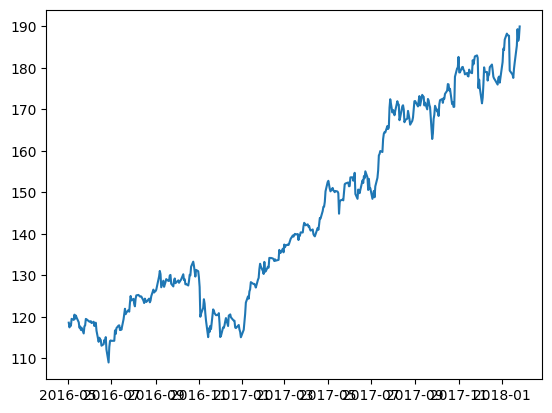

In [88]:
#Graficamos la serie dt.
plt.plot(dt)

##### 4. Pre procesamiento de datos

In [89]:
#Ahora, pasamos el data frame a un objeto de tiempo de pandas.
dataindex= pd.to_datetime(dt.index)

In [90]:
#Ahora, a numpy array:
dt2= meta.to_numpy()

In [91]:
#Y generamos un rearreglo de la dimensión del array a 1D, en los renglones (el -1 signigica que numpy calcula este número por nosotros).
close_data = dt2.reshape((-1,1))

##### 5. Partición de datos de entrenamiento y prueba

In [92]:
#Especificamos primeramente el porcentje del corte.
split_percent = 0.95
split = int(split_percent*len(close_data))

#Aplicamos dicha proporción a la definición de la parte de entrenamiento y de prueba.
close_train = close_data[:split]
close_test = close_data[split:]

date_train = dataindex[:split]
date_test = dataindex[split:]

In [93]:
#imprimimos la longitud de ambos conjuntos de datos:
print(len(close_train))
print(len(close_test))

417
22


##### 6. Definición de la estructura de los datos transformada

In [94]:
#Especificamos la longitud o length, es el número de observaciones tipo lags a emplear en la prción de entrada de cada muestra, el ejemplo anterior era de 3.
#batch size representa en número de sub-series o muestras a generar en cada lote. En este caso, pueden ser uno o más. Por ejemplo, en la imagen anterior, el batch size es de 3.
n_back = 15   #la longitud 
train_generator = TimeseriesGenerator(close_train, close_train, length=n_back, batch_size=25)     
test_generator = TimeseriesGenerator(close_test, close_test, length=n_back, batch_size=1)

In [95]:
# Podemos ver el número de muestras que se prepararán en los datos por el generador para esta serie
print('Samples: %d' % len(train_generator))
print('Samples: %d' % len(test_generator))

Samples: 17
Samples: 7


##### 7. Diseño y entrenamiento de la red neuronal

In [96]:
#Configuramos la de red.
model = Sequential()
model.add(
    LSTM(200,  ## de nodos, dependerá de su poder de cómputo.
        activation='relu',
        input_shape=(n_back,1))   ##la longitud de la secuencia
)
model.add(Dense(1))  #capa de salida de predicción
model.compile(optimizer='adam', loss='mse')

num_epochs = 30
model.fit_generator(train_generator, epochs=num_epochs, verbose=0)

In [97]:
##Ajuste del modelo a los datos:
history = model.fit_generator(train_generator, epochs=num_epochs, verbose=0)

In [98]:
#Imprimimos gráfico de funión de pérdida acorde los epochs
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

plot_data = [
    go.Scatter(
        x=hist['epoch'],
        y=hist['loss'],
        name='loss'
    )
]

plot_layout = go.Layout(
        title='Training loss')
fig = go.Figure(data=plot_data, layout=plot_layout)
fig.show()

##### 8. Incrustación del modelo en la estructura de datos para pronóstico de prueba

In [99]:
#Predicción en el set de prueba:
prediction = model.predict_generator(test_generator)

#El siguiente se emplea para pasar el tipo de datos de tensores a datos de una dimensión, aplicamos la función reshape.
close_train = close_train.reshape((-1))
close_test = close_test.reshape((-1))
prediction = prediction.reshape((-1))

In [100]:
#Podemos primeramente graficar las secciones: la serie de entrenamiento, la predicción en la sección de prueba y la sección de prueba.
trace1 = go.Scatter(
    x = date_train,
    y = close_train,
    mode = 'lines',
    name = 'Data'
)
trace2 = go.Scatter(
    x = date_test,
    y = prediction,
    mode = 'lines',
    name = 'Prediction'
)
trace3 = go.Scatter(
    x = date_test,
    y = close_test,
    mode='lines',
    name = 'Reality'
)
layout = go.Layout(
    title = "Meta Stock",
    xaxis = {'title' : "Date"},
    yaxis = {'title' : "Close"}
)
fig = go.Figure(data=[trace1, trace2, trace3], layout=layout)
fig.show()

In [101]:
##Identificamos la posición del último valor de la serie.
dataindex[438]

Timestamp('2018-01-26 00:00:00')

In [102]:
##Forecasting: Generamos el pronóstico hacia adelante acorde el modelo entrenado, a partir de la última fecha. en este caso generaremos 10 observaciones futuras y finalmente anexaremos las fechas correspondientes.
close_data = close_data.reshape((-1))

def predict(num_prediction, model):
    prediction_list = close_data[-n_back:]
    
    for _ in range(num_prediction):
        x = prediction_list[-n_back:]
        x = x.reshape((1, n_back, 1))
        out = model.predict(x)[0][0]
        prediction_list = np.append(prediction_list, out)
    prediction_list = prediction_list[n_back-1:]
        
    return prediction_list
    
def predict_dates(num_prediction):
    last_date = dataindex[438]
    prediction_dates = pd.date_range(last_date, periods=num_prediction+1).tolist()
    return prediction_dates

num_prediction = 10
forecast = predict(num_prediction, model)
forecast_dates = predict_dates(num_prediction)

1/1 [==============================] - 0s 26ms/step


In [103]:
#Podemos observar las fechas hacia adelante.
forecast_dates

[Timestamp('2018-01-26 00:00:00', freq='D'),
 Timestamp('2018-01-27 00:00:00', freq='D'),
 Timestamp('2018-01-28 00:00:00', freq='D'),
 Timestamp('2018-01-29 00:00:00', freq='D'),
 Timestamp('2018-01-30 00:00:00', freq='D'),
 Timestamp('2018-01-31 00:00:00', freq='D'),
 Timestamp('2018-02-01 00:00:00', freq='D'),
 Timestamp('2018-02-02 00:00:00', freq='D'),
 Timestamp('2018-02-03 00:00:00', freq='D'),
 Timestamp('2018-02-04 00:00:00', freq='D'),
 Timestamp('2018-02-05 00:00:00', freq='D')]

##### 10. Visualización del pronóstico hacia adelante

In [104]:
#Graficamos la serie anterior, aunando el valor del pronóstico.
trace1 = go.Scatter(
    x = date_train,
    y = close_train,
    mode = 'lines',
    name = 'Data'
)
trace2 = go.Scatter(
    x = date_test,
    y = prediction,
    mode = 'lines',
    name = 'Prediction'
)
trace3 = go.Scatter(
    x = date_test,
    y = close_test,
    mode='lines',
    name = 'Reality'
)
trace4 = go.Scatter(
    x = forecast_dates,
    y = forecast,
    mode='lines',
    name = 'FWD Forecast'
)

layout = go.Layout(
    title = "Meta Stock",
    xaxis = {'title' : "Date"},
    yaxis = {'title' : "Close"}
)
fig = go.Figure(data=[trace1, trace2, trace3, trace4], layout=layout)
fig.show()

##### 10. Conlusión sobre el Modelo

In [105]:
res = model.evaluate(test_generator)
print('MSE:',res)

7/7 [==============================] - 0s 4ms/step - loss: 68.0859
MSE: 68.08586883544922
